## SHAP

In [23]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path



os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
print('Seed: 42')




Seed: 42


In [24]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle

def get_best_model():
    # TODO: SAVE BEST MODEL FROM NOTEBOOK2 TO PICKLE FILE AND LOAD
    with open('../best_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    return LGBMClassifier()
    return loaded_model

In [25]:
# Data
import pandas as pd
def read_csv(file_path):
    df = pd.read_csv(file_path)
    # display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print('Shape df ', df.shape)
    print('Shape X', X.shape)
    print('Shape y: ', y.shape)
    return X, y
dir = '../splits'
X_train, y_train = read_csv(f'{dir}/raw_train.csv')
X_test, y_test = read_csv(f'{dir}/raw_test.csv')
X_val, y_val = read_csv(f'{dir}/raw_val.csv')


target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 14)
Shape X (242, 13)
Shape y:  (242,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 14)
Shape X (31, 13)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 14)
Shape X (30, 13)
Shape y:  (30,)


In [26]:
model = get_best_model()
model.fit(X_train, y_train)  # cần fit trước

[LightGBM] [Info] Number of positive: 111, number of negative: 131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458678 -> initscore=-0.165667
[LightGBM] [Info] Start training from score -0.165667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [27]:
# Use samples from both training and test sets
X_train_sample = X_train.sample(min(500, len(X_train)), random_state=42)
X_test_sample = X_test.sample(min(500, len(X_test)), random_state=42)
X_sample = pd.concat([X_train_sample, X_test_sample])

In [28]:
# Create a SHAP explainer
import shap
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

c:\Users\USER\anaconda3\envs\ml\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Top 10 most important features globally:
 feature  importance
      ca    1.121106
      cp    1.032863
    thal    0.988601
     sex    0.759349
   slope    0.603677
     age    0.509137
 oldpeak    0.466248
    chol    0.392456
 thalach    0.381935
trestbps    0.331055


C:\Users\USER\AppData\Local\Temp\ipykernel_2368\885624548.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)


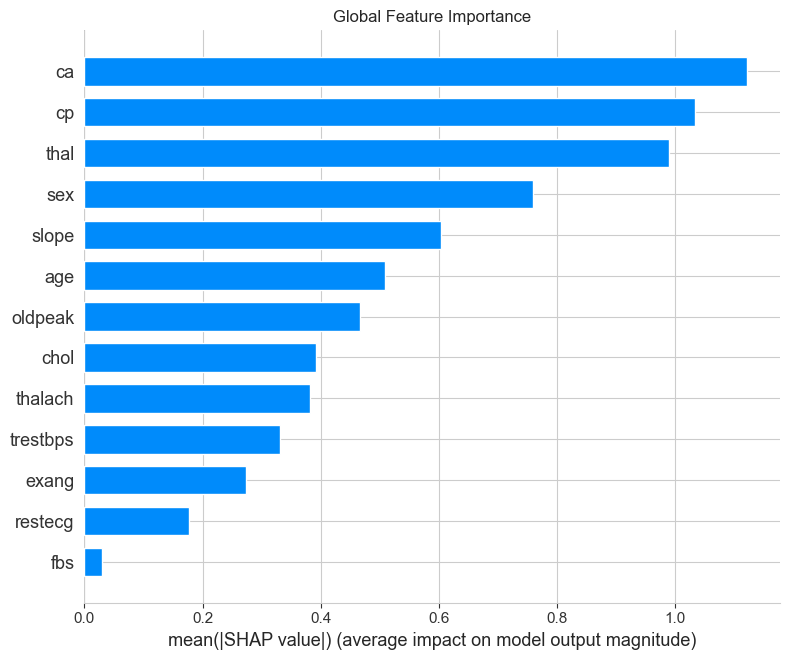

In [29]:
# Global feature importance
print("Top 10 most important features globally:")
feature_importance = pd.DataFrame(
    {"feature": X_sample.columns, "importance": np.abs(shap_values).mean(axis=0)}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
print(feature_importance.head(10).to_string(index=False))

# Global feature importance plot
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Global Feature Importance")
plt.tight_layout()

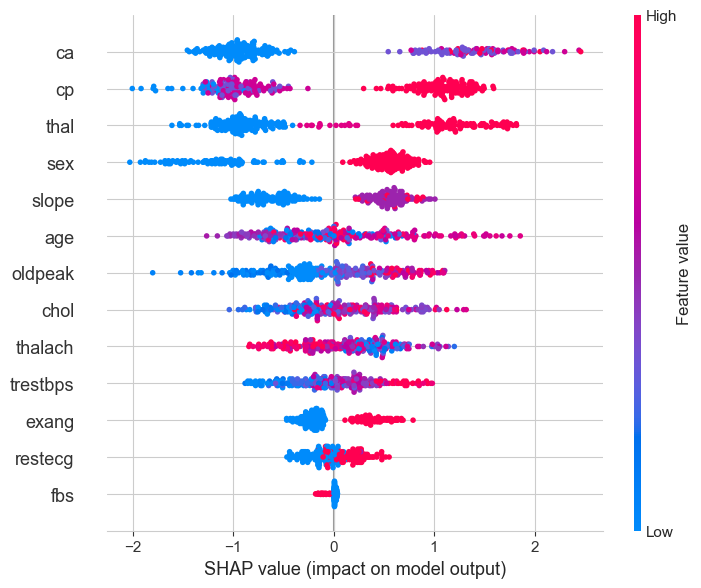

In [30]:
# Summarize the effects of all the features
shap.plots.beeswarm(explainer(X_sample), max_display=20)

## Các đặc trưng quan trọng nhất
🔹 ca (Số mạch máu chính nhuộm màu)

Là yếu tố ảnh hưởng mạnh nhất.

Giá trị thấp (0–1 mạch) (màu xanh) → SHAP dương → tăng khả năng bệnh.

Giá trị cao (2–3 mạch) (màu đỏ) → SHAP âm → giảm nguy cơ.

👉 Người có nhiều mạch máu chính được nhuộm màu rõ ràng thường ít bị bệnh tim hơn.

🔹 cp (Loại đau ngực)

Các loại đau ngực khác nhau ảnh hưởng mạnh:

cp = 1 (đau thắt ngực điển hình) → SHAP dương (nguy cơ cao).

cp = 4 (không triệu chứng) → SHAP âm (nguy cơ thấp).

👉 Đặc trưng này giúp phân loại bệnh nhân rất rõ rệt.

🔹 thal (Thalassemia)

thal = 3 (bình thường) → SHAP âm → giảm nguy cơ.

thal = 6 hoặc 7 (bất thường) → SHAP dương → tăng nguy cơ.

🔹 sex (Giới tính)

Nam (1) (màu đỏ) thường có SHAP dương → nguy cơ cao hơn.

Nữ (0) (màu xanh) thường có SHAP âm → nguy cơ thấp hơn.

🔹 slope (Độ dốc đoạn ST)

slope cao (2–3) → SHAP dương → nguy cơ tăng.

slope thấp (1) → SHAP âm → ít nguy cơ.

🔹 age (Tuổi)

Tuổi cao (màu đỏ) → SHAP dương → nguy cơ bệnh tăng.

Tuổi trẻ → SHAP âm → ít nguy cơ.